In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data = "..\\data\\CombinedData.csv"
df = pd.read_csv(raw_data)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
df.describe()

,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df.isna().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [6]:
df.dropna(inplace = True)
df.isna().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [7]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

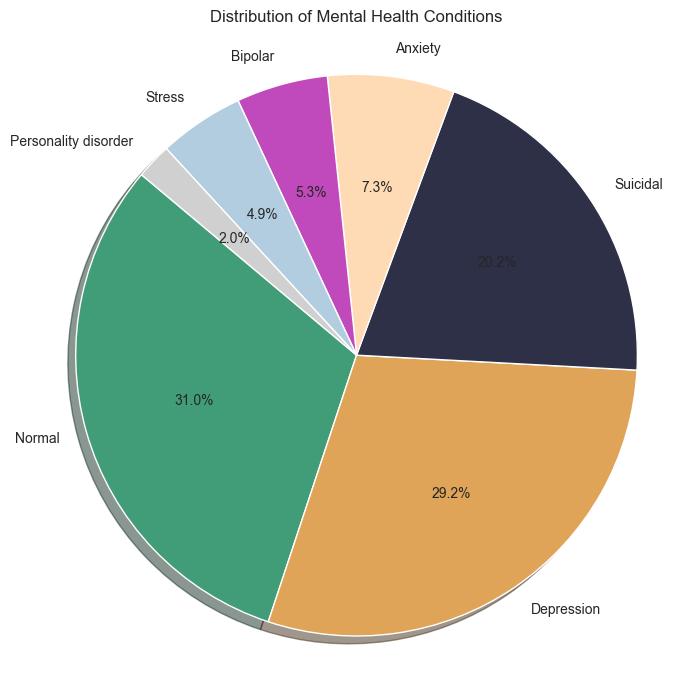

In [8]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [9]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Evening HA into sleepless night Around 8pm I had that familiar chest pain. A deep burning ache on the right side of my chest. I had a crappy nights sleep the night  before, approx 4 hours, and was so tired all day. But with the anxiety tonight, every time I would start to fall asleep I would wake up suddenly. Jolted wide awake. I’ve watched QVC, twitch streams, parks and rec. I’ve done calm.com, YouTube sleep hypnosis and chatted on Pacifica. I’ve read my book and meditated. Nothing helped tonight and I’ve literally slept zero minutes. My alarm will go off in one hour and I’m horrified about what tomorrow will be like. 

I have four children who need rides starting at 7am and ending at 8:30pm. I have a job where I have responsibilities to my coworkers. 

Please tell me that I’m going to be alright. Sorry to whine I’m just really discouraged.

Status: Bipolar
Statement: Insecure in relationship - TW: suicide I had a serious suicide attempt a few days ago where

In [10]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [11]:
df[df['num_of_characters'] > 10000]

,Unnamed: 0,statement,status,num_of_characters,num_of_sentences
7851,7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180
